In [58]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.diagnostic import het_breuschpagan

import warnings
warnings.filterwarnings("ignore")




In [59]:
df = pd.read_csv("C:\\Users\\jonga\\Downloads\\regression_features(in).csv")
print("Dataset shape:", df.shape)
df.head()



Dataset shape: (206209, 14)


,user_id,order_id,order_number,order_dow,order_hour_of_day,days_since_prior_order,total_orders,reorder_ratio,mean_days_between_orders,last_order_recency,avg_basket_size,mean_days_last3,avg_basket_size_last3,total_orders_log
0,1,2550362,10,4,8,30,10,0.694915,18.542374,30,5.900000,14.666667,7.000000,2.397895
1,2,839880,14,3,10,13,14,0.476923,14.902564,13,13.928571,23.666666,14.666667,2.708050
2,3,1402502,12,1,15,15,12,0.625000,10.181818,15,7.333333,14.333333,5.666667,2.564949
3,4,2557754,5,5,13,0,5,0.055556,11.944445,0,3.600000,12.000000,4.000000,1.791759
4,5,157374,4,1,18,19,4,0.378378,10.189189,19,9.250000,13.333333,8.666667,1.609438


In [ ]:


df['days_for_next_order'] = df['days_since_prior_order'] / df['reorder_ratio']


df['days_for_next_order'] = df['days_for_next_order'].replace([np.inf, -np.inf], np.nan)
df['days_for_next_order'] = df['days_for_next_order'].fillna(df['days_for_next_order'].median())


df['days_for_next_order'] = df['days_for_next_order'].clip(
    lower=df['days_for_next_order'].quantile(0.01),
    upper=df['days_for_next_order'].quantile(0.99)
)


X = df.drop(columns=['days_for_next_order', 'user_id', 'order_id'])
y = df['days_for_next_order']





Index(['user_id', 'order_id', 'order_number', 'order_dow', 'order_hour_of_day',
       'days_since_prior_order', 'total_orders', 'reorder_ratio',
       'mean_days_between_orders', 'last_order_recency', 'avg_basket_size',
       'mean_days_last3', 'avg_basket_size_last3', 'total_orders_log'],
      dtype='object')


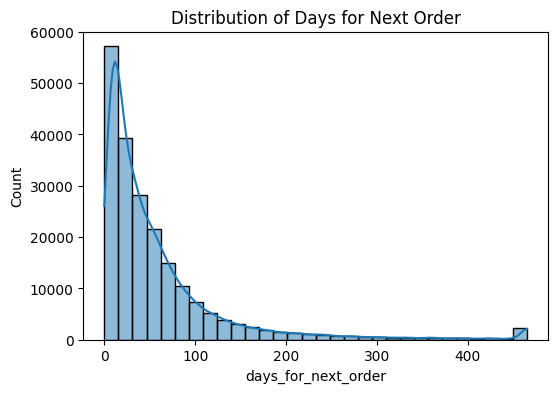

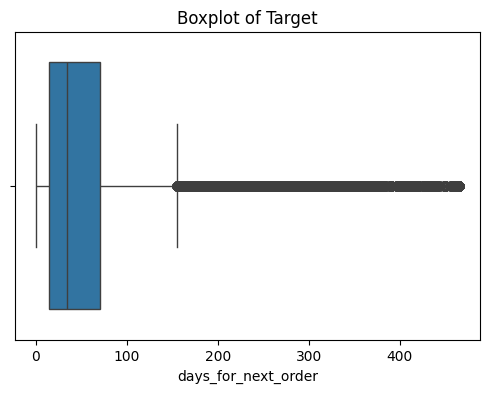

In [61]:
plt.figure(figsize=(6,4))
sns.histplot(df["days_for_next_order"], bins=30, kde=True)
plt.title("Distribution of Days for Next Order")
plt.show()

plt.figure(figsize=(6,4))
sns.boxplot(x=df["days_for_next_order"])
plt.title("Boxplot of Target")
plt.show()



In [62]:
target = "days_for_next_order"
X = df.drop(columns=[target])
y = df[target]






In [63]:


X_numeric = X.select_dtypes(include=[np.number])
X_scaled = StandardScaler().fit_transform(X_numeric)

vif_df = pd.DataFrame()
vif_df["feature"] = X_numeric.columns
vif_df["VIF"] = [variance_inflation_factor(X_scaled, i) for i in range(X_scaled.shape[1])]
vif_df.sort_values("VIF", ascending=False)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False
)

numeric_features = X.select_dtypes(include=[np.number]).columns.tolist()
preprocessor = ColumnTransformer([
    ("num", StandardScaler(), numeric_features)
], remainder="drop")




===== Linear Regression =====
Train MAE: 29.171100268015298
Train RMSE: 49.528851824652484
Train R2: 0.5691937856798985
Test MAE: 29.076612077139433
Test RMSE: 49.2849950878092
Test R2: 0.5697749310912794


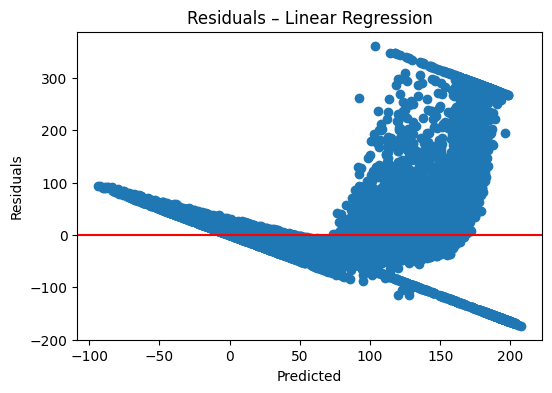

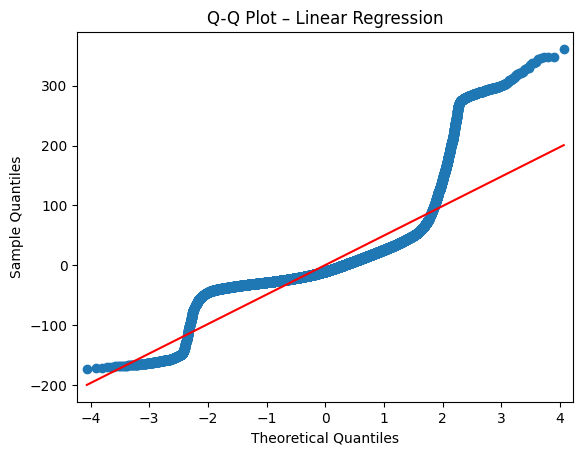

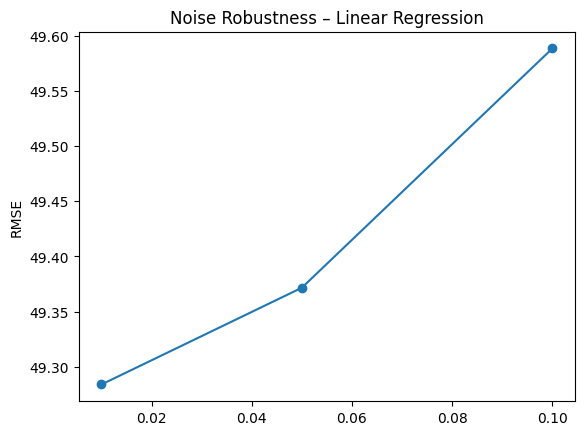

In [64]:


model_name = "Linear Regression"
pipe = Pipeline([
    ("preprocess", preprocessor),
    ("model", LinearRegression())
])

pipe.fit(X_train, y_train)
train_preds = pipe.predict(X_train)
test_preds = pipe.predict(X_test)


print(f"===== {model_name} =====")
print("Train MAE:", mean_absolute_error(y_train, train_preds))
print("Train RMSE:", np.sqrt(mean_squared_error(y_train, train_preds)))
print("Train R2:", r2_score(y_train, train_preds))
print("Test MAE:", mean_absolute_error(y_test, test_preds))
print("Test RMSE:", np.sqrt(mean_squared_error(y_test, test_preds)))
print("Test R2:", r2_score(y_test, test_preds))


residuals = y_test - test_preds
plt.figure(figsize=(6,4))
plt.scatter(test_preds, residuals)
plt.axhline(0, color='red')
plt.title(f"Residuals – {model_name}")
plt.xlabel("Predicted")
plt.ylabel("Residuals")
plt.show()


sm.qqplot(residuals, line='s')
plt.title(f"Q-Q Plot – {model_name}")
plt.show()


noise_levels = [0.01, 0.05, 0.1]
robustness = {}
for level in noise_levels:
    X_noisy = X_test + np.random.normal(0, level * X_test.std(), X_test.shape)
    preds_noisy = pipe.predict(X_noisy)
    robustness[level] = np.sqrt(mean_squared_error(y_test, preds_noisy))
pd.Series(robustness).plot(marker='o')
plt.title(f"Noise Robustness – {model_name}")
plt.ylabel("RMSE")
plt.show()






===== Ridge Regression =====
Train RMSE: 49.528851826957776
Train R2: 0.5691937856397954
Test RMSE: 49.284990938650694
Test R2: 0.569775003530038


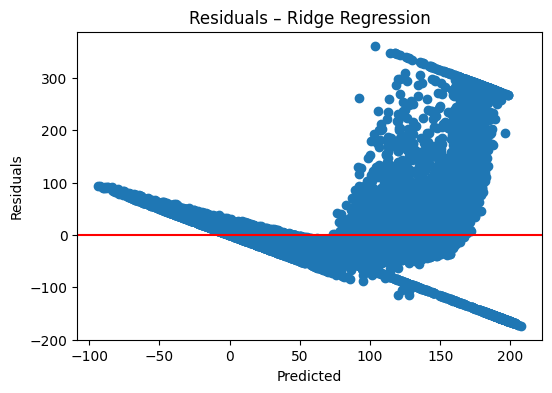

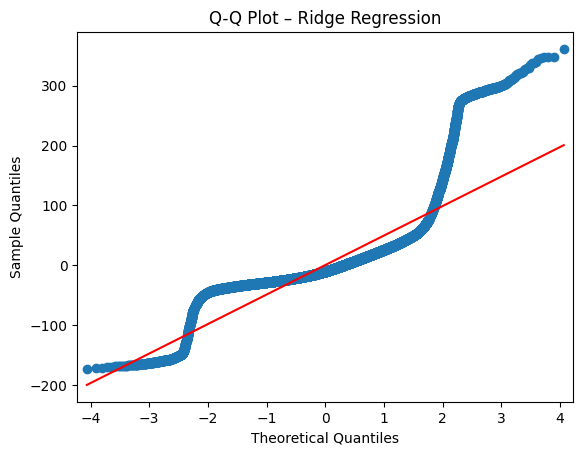

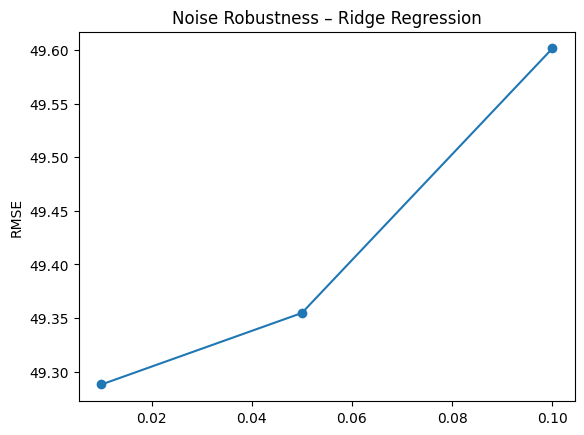

In [65]:

model_name = "Ridge Regression"
pipe = Pipeline([
    ("preprocess", preprocessor),
    ("model", Ridge(alpha=1.0))
])

pipe.fit(X_train, y_train)
train_preds = pipe.predict(X_train)
test_preds = pipe.predict(X_test)

print(f"===== {model_name} =====")
print("Train RMSE:", np.sqrt(mean_squared_error(y_train, train_preds)))
print("Train R2:", r2_score(y_train, train_preds))
print("Test RMSE:", np.sqrt(mean_squared_error(y_test, test_preds)))
print("Test R2:", r2_score(y_test, test_preds))


residuals = y_test - test_preds
plt.figure(figsize=(6,4))
plt.scatter(test_preds, residuals)
plt.axhline(0, color='red')
plt.title(f"Residuals – {model_name}")
plt.xlabel("Predicted")
plt.ylabel("Residuals")
plt.show()


sm.qqplot(residuals, line='s')
plt.title(f"Q-Q Plot – {model_name}")
plt.show()


robustness = {}
for level in noise_levels:
    X_noisy = X_test + np.random.normal(0, level * X_test.std(), X_test.shape)
    preds_noisy = pipe.predict(X_noisy)
    robustness[level] = np.sqrt(mean_squared_error(y_test, preds_noisy))
pd.Series(robustness).plot(marker='o')
plt.title(f"Noise Robustness – {model_name}")
plt.ylabel("RMSE")
plt.show()


===== Random Forest =====
Train RMSE: 0.25390291825553746
Train R2: 0.9999886785820429
Test RMSE: 0.5206022466668458
Test R2: 0.999951995897591


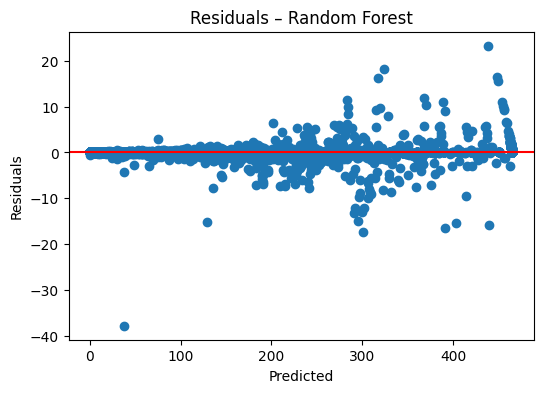

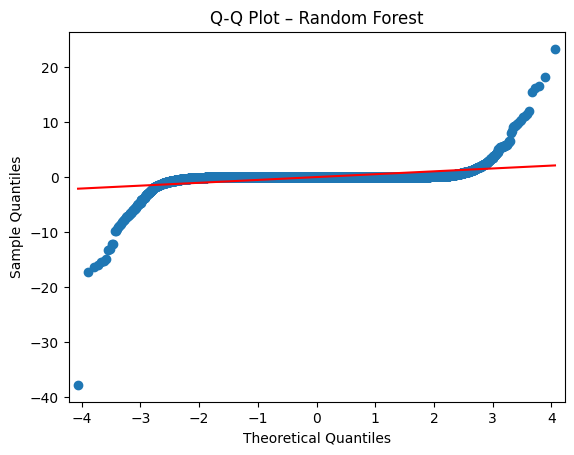

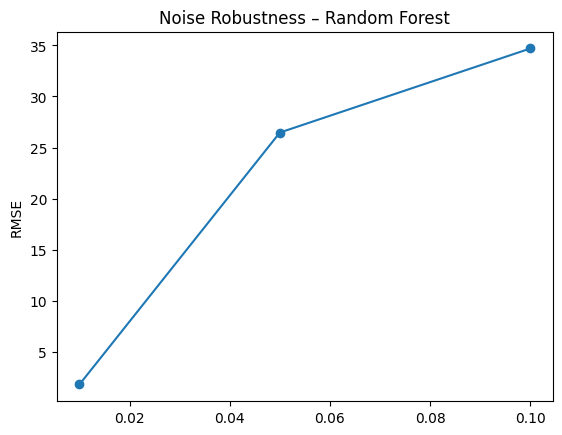

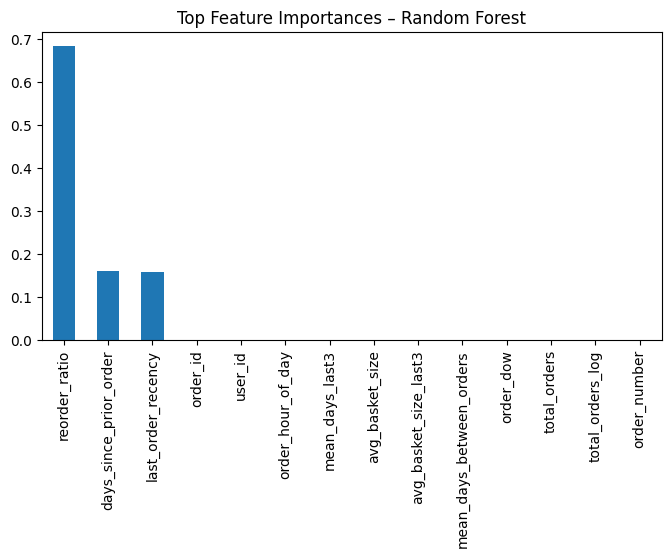

In [66]:

model_name = "Random Forest"
pipe = Pipeline([
    ("preprocess", preprocessor),
    ("model", RandomForestRegressor(n_estimators=300, random_state=42))
])

pipe.fit(X_train, y_train)
train_preds = pipe.predict(X_train)
test_preds = pipe.predict(X_test)

print(f"===== {model_name} =====")
print("Train RMSE:", np.sqrt(mean_squared_error(y_train, train_preds)))
print("Train R2:", r2_score(y_train, train_preds))
print("Test RMSE:", np.sqrt(mean_squared_error(y_test, test_preds)))
print("Test R2:", r2_score(y_test, test_preds))


residuals = y_test - test_preds
plt.figure(figsize=(6,4))
plt.scatter(test_preds, residuals)
plt.axhline(0, color='red')
plt.title(f"Residuals – {model_name}")
plt.xlabel("Predicted")
plt.ylabel("Residuals")
plt.show()


sm.qqplot(residuals, line='s')
plt.title(f"Q-Q Plot – {model_name}")
plt.show()


robustness = {}
for level in noise_levels:
    X_noisy = X_test + np.random.normal(0, level * X_test.std(), X_test.shape)
    preds_noisy = pipe.predict(X_noisy)
    robustness[level] = np.sqrt(mean_squared_error(y_test, preds_noisy))
pd.Series(robustness).plot(marker='o')
plt.title(f"Noise Robustness – {model_name}")
plt.ylabel("RMSE")
plt.show()

# Feature Importance
importances = pipe.named_steps['model'].feature_importances_
imp_df = pd.Series(importances, index=numeric_features).sort_values(ascending=False)
imp_df.head(15).plot(kind='bar', figsize=(8,4))
plt.title(f"Top Feature Importances – {model_name}")
plt.show()



===== Gradient Boosting =====
Test RMSE: 2.7410530745161563
Test R2: 0.9986692356218233


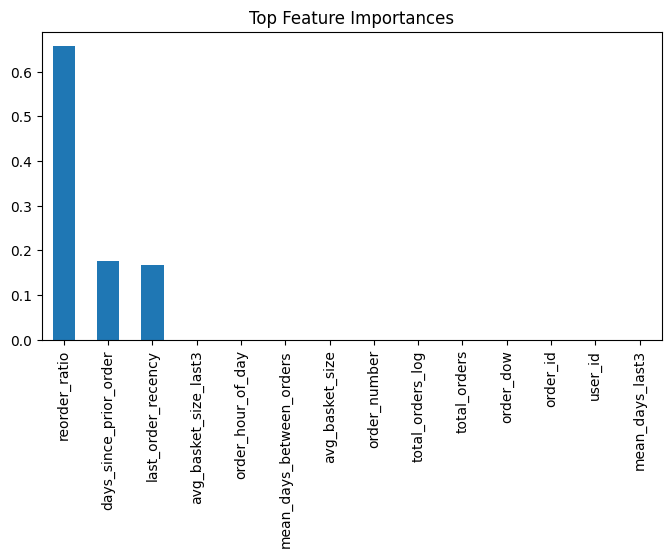

In [67]:
model_name = "Gradient Boosting"
model = Pipeline([
    ("preprocess", preprocessor),
    ("model", GradientBoostingRegressor(n_estimators=300, random_state=42))
])

model.fit(X_train, y_train)
test_preds = model.predict(X_test)

print(f"===== {model_name} =====")
print("Test RMSE:", np.sqrt(mean_squared_error(y_test, test_preds)))
print("Test R2:", r2_score(y_test, test_preds))


importances = model.named_steps["model"].feature_importances_
imp_df = pd.Series(importances, index=numeric_features).sort_values(ascending=False)
imp_df.head(15).plot(kind="bar", figsize=(8,4))
plt.title("Top Feature Importances")
plt.show()


In [68]:
X_sm = sm.add_constant(test_preds)
bp_test = het_breuschpagan(y_test - test_preds, X_sm)
bp_test  


(np.float64(1109.8248865612818),
 np.float64(2.418300887447034e-243),
 np.float64(1140.4609441779512),
 np.float64(1.2399447966760755e-246))